# Introduction - Video Game Sales Analysis

I am working with a dataset provided to me by Practicum for use in this project. The data deals with video game sales through 2016, and my goal is to uncover patterns that can determine whether or not a game succeeds for 2017, the year following the end of the dataset. We will eventually have to settle on a span of years to use for our analysis, but as I preprocess the data before this decision, I will dedicate some focus to data from 2013 and on, since that is the first full year following the Xbox One and PS4 release in late 2012. 

Our first step will be to preprocess the data - deal with column names, datatypes, duplicates, and missing values, and add a total sales column for each row.

Then we will check out the numbers through the years and decide whether we want to use all of the data, or just data from recent years. We also want to figure out the typical lifespan of a console, and which consoles have been performing exceptionally well or poorly recently. We can compare total/average global sales across platforms to help with this. We will look at the correlation between reviews and sales for the Xbox One platform, and then compare the top games for this console to the sales on other consoles. We will then try to determine any patterns behind the most and least profitable genres.

After that we will look at each region and identify the top platforms and genres for each one, and determine whether or not the games' ESRB ratings affect sales.

Finally I will use statistical tests to:

    - Compare average user ratings of the Xbox One and PC platforms (t-test with independent samples)
    - Compare average user ratings for the Action and Sports genres (t-test with independent samples)
    - Compare typical user ratings of the Xbox One, PC, PS4, and WiiU platforms (one-way ANOVA test, tukey test)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import statistical testing functions
from scipy.stats import levene
from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd as tukey
from scipy.stats import kruskal

In [2]:
df = pd.read_csv('moved_games.csv') # Read in dataset

# Preprocessing

## Initial exploration and edits

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Name, platform, genre, and all sales columns appear to be essentially complete. Many of the number columns are already in the correct datatype. I will need to look into user score and fix whatever is preventing it from being a float type.

First let's fix the column names.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head() # Check out data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
df.duplicated().sum() # Check for fully duplicate rows

0

In [7]:
desc = df.describe(include='all') # Let's check out an overview of the summary statistics to see if values make sense
display(desc)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
count,16713,16715,16446.000000,16713,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,10014,9949
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,E
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,2424,3990
mean,NaN,NaN,2006.484616,NaN,0.263377,0.145060,0.077617,0.047342,68.967679,NaN,NaN
std,NaN,NaN,5.877050,NaN,0.813604,0.503339,0.308853,0.186731,13.938165,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


Platform seems good. Year_of_release tells us that the data ranges from 1980 to 2016. Genre, sales columns, rating, and critic_score all look reasonable. 

Name seems to have some duplicates, let's look into that later.

User_score has a high number of "tbd" scores, which may correlate with recently released games whose scores have not been reported yet - I will check this. 

## User scores

I want this column to be numeric type so that I can perform calculations, so I will turn these "tbd" values into nans. As the data is updated, it can be fed into this notebook and all calculations can be rerun to improve precision.

In [8]:
# Look at years where at least one user score is tbd
df_tbd = df[df.user_score == 'tbd']
print(sorted(df_tbd.year_of_release.unique()))

# Hmm, there is a wide spread of years. How many are from 2016?
tbd_2016 = df_tbd.query('year_of_release == 2016').count()['year_of_release']
print("Number of 'tbd' games from 2016:", tbd_2016)

[1997.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, nan, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0]
Number of 'tbd' games from 2016: 34


Text(0.5, 1.0, 'How many games each year had a tbd user score?')

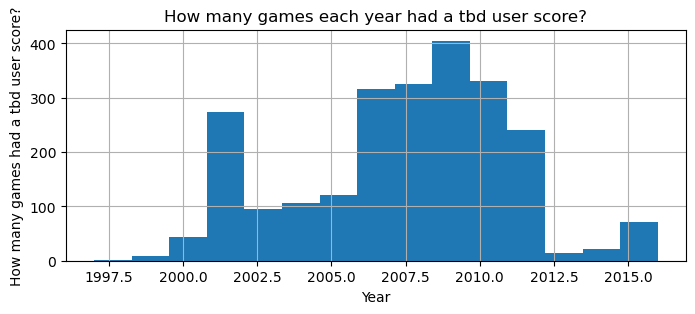

In [9]:
# Plot distribution of tbd games per year to see an overview
df_tbd.year_of_release.hist(bins=15, figsize=[8,3])
plt.xlabel("Year")
plt.ylabel("How many games had a tbd user score?")
plt.title("How many games each year had a tbd user score?")

Wow, it looks like very few of these 'tbd' games were from 2016. Let's quantify the ratio.

In [10]:
ratio_2016_tbd = tbd_2016 / desc.loc['freq', 'user_score']
ratio_2016_tbd

0.014026402640264026

Only a very small percentage of tbd's come from 2016. It appears that the vast majority of the 'tbd' data may never arrive. The data user score data for these older games most likely does not exist. Let's go ahead and turn them all into nans, and change datatypes to float. Assigning these 'tbd' values an arbitrary values like '999' could work too, but keeping them nans should make analysis easier later, and the nans will be straightforward to handle within the limited scope of this project.

In [11]:
df.user_score = df.user_score.apply(pd.to_numeric, errors='coerce')

In [12]:
df.info() # Verify success

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


User score has dropped the tbd values and became float datatype. I want to now look at year_of_release to determine why they are not integers.

## Year of Release

In [13]:
print(df.year_of_release.unique())
print(df.year_of_release.isna().sum())
df[df.year_of_release.isna()].head(10)

[2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]
269


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,NaN,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


I find it disappointing that a lot of game titles that I recognize have NaN years of release. Doing research on the games and filling in the years of release by hand would be too time consuming. I want to look at how many titles for Xbox One, PS4, and Wii U are missing years of release, as these were the newest popular platforms in 2016.

In [14]:
print(df.platform.unique()) # Look at how these consoles are notated
df[(df.year_of_release.isna()) & ((df.platform == 'XOne') | (df.platform == 'PS4') | (df.platform == 'WiiU'))]

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Okay, great. It looks like the years of release are complete for these three newest platforms. Perhaps the data was missing for older platforms because it is relatively unimportant compared to the data for newer consoles, and whoever created this dataset was trying to save time.

Let's replace nan's here with 0. A zero will clearly be separate from the rest of the years. The years can be changed to int, now that the nans are gone - the computer can use the ints more effectively and save on memory, while still knowing the inherent order of the years.

In [15]:
df.year_of_release = df.year_of_release.fillna(0)
df.year_of_release = df.year_of_release.astype('int')

In [16]:
df.info() # Verify success

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


I want to look at the ratings column.

## Rating

In [17]:
df.rating.unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Some internet research reveals that 'K-A' is a precursor equivalent to 'E'. I will change these to 'E' for simplicity.

'RP' means the rating is pending. Let's look to see if this only applies to a small number of 2016 games.

In [18]:
df.rating = df.rating.replace('K-A', 'E') # Change 'K-A' to 'E'

df.query('rating=="RP"').count()['name']

3

Let's look at all games with missing ratings.

In [19]:
df[df.rating.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Let's look at games released in the last few years of the dataset (2013 and on) with missing ratings.

In [20]:
display(df[df.rating.isna() & (df.year_of_release >= 2013)].head(10))
df[df.rating.isna() & (df.year_of_release >= 2013)].count()['name']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,NaN
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN
96,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,NaN
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,NaN
180,Minecraft,PS3,2014,Misc,2.03,2.37,0.00,0.87,NaN,NaN,NaN
184,Tomodachi Life,3DS,2013,Simulation,0.97,2.11,1.90,0.24,NaN,NaN,NaN


977

At a glance, I am disappointed by how many well-known titles are missing ratings (and critic/user scores, for that matter). However, there are less than 1000 missing ratings for these newer games, compared to ~6800 games in total with missing ratings, so the data seems relatively intact. Perhaps the ratings are missing because the creator of the dataset felt they were not important.

Very few games have an 'RP' rating. Let's change nans into 'RP' rating for simplicity, as they each indicate a non-rating.

In [21]:
df.rating = df.rating.fillna('RP')

In [22]:
df.rating.unique() # Verify success
df.rating = df.rating.astype('category') # Change datatype to categorical

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  object  
 1   platform         16715 non-null  object  
 2   year_of_release  16715 non-null  int32   
 3   genre            16713 non-null  object  
 4   na_sales         16715 non-null  float64 
 5   eu_sales         16715 non-null  float64 
 6   jp_sales         16715 non-null  float64 
 7   other_sales      16715 non-null  float64 
 8   critic_score     8137 non-null   float64 
 9   user_score       7590 non-null   float64 
 10  rating           16715 non-null  category
dtypes: category(1), float64(6), int32(1), object(3)
memory usage: 1.2+ MB


## Genre

In [24]:
df.genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [25]:
genre_nan = df[df.genre.isna()]
genre_nan

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,RP
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,RP


There are only two nans. Let's just turn these into 'Misc'. These nans are attached to rows with mostly other nan data, so it seems that the dataset creator could not find much information on these games.

In [26]:
df.genre = df.genre.fillna('Misc')

# I will also change the datatype to save memory.
df.genre = df.genre.astype('category')

In [27]:
df.info() # Verify success

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  object  
 1   platform         16715 non-null  object  
 2   year_of_release  16715 non-null  int32   
 3   genre            16715 non-null  category
 4   na_sales         16715 non-null  float64 
 5   eu_sales         16715 non-null  float64 
 6   jp_sales         16715 non-null  float64 
 7   other_sales      16715 non-null  float64 
 8   critic_score     8137 non-null   float64 
 9   user_score       7590 non-null   float64 
 10  rating           16715 non-null  category
dtypes: category(2), float64(6), int32(1), object(2)
memory usage: 1.1+ MB


## Name

I mainly want to look for duplicates in this name column and see whether or not they should be removed.

In [28]:
df.duplicated(subset='name').sum()

5155

That's a lot of duplicate names. However, games tend to come out on a variety of platforms. Some games may share a name and platform but are totally distinct, coming out in a different year. Let's add these to the subsets.

In [29]:
dups = df[df.duplicated(subset=['name', 'platform', 'year_of_release'])]
madden = dups.loc[16230, 'name']

Two duplicates - let's first deal with the nan.

In [30]:
df[df.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,Misc,1.78,0.53,0.00,0.08,NaN,NaN,RP
14244,NaN,GEN,1993,Misc,0.00,0.00,0.03,0.00,NaN,NaN,RP


These are probably two separate games. Let's replace the nan names with "Unknown". These are from the rows we looked at earlier with lots of missing information, so these nan names are not surprising.

In [31]:
df.name = df.name.fillna('Unknown')

Now let's deal with the Madden game.

In [32]:
df[df.name == madden]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


So, rows 604 and 16230 are essentially duplicates. I'll add the sales from row 16230 to row 604, effectively combining them, before removing row 16230.

In [33]:
df.loc[604, 'eu_sales'] = df.loc[604, 'eu_sales'] + df.loc[16230, 'eu_sales']
df = df.drop(index=16230).reset_index(drop=True)

In [34]:
df[df.name == madden] # Verify success

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16714 non-null  object  
 1   platform         16714 non-null  object  
 2   year_of_release  16714 non-null  int32   
 3   genre            16714 non-null  category
 4   na_sales         16714 non-null  float64 
 5   eu_sales         16714 non-null  float64 
 6   jp_sales         16714 non-null  float64 
 7   other_sales      16714 non-null  float64 
 8   critic_score     8136 non-null   float64 
 9   user_score       7589 non-null   float64 
 10  rating           16714 non-null  category
dtypes: category(2), float64(6), int32(1), object(2)
memory usage: 1.1+ MB


## Platform

I'm just going to check out the platforms and change datatype to category. There are no missing values.

In [36]:
df.platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16714 non-null  object  
 1   platform         16714 non-null  object  
 2   year_of_release  16714 non-null  int32   
 3   genre            16714 non-null  category
 4   na_sales         16714 non-null  float64 
 5   eu_sales         16714 non-null  float64 
 6   jp_sales         16714 non-null  float64 
 7   other_sales      16714 non-null  float64 
 8   critic_score     8136 non-null   float64 
 9   user_score       7589 non-null   float64 
 10  rating           16714 non-null  category
dtypes: category(2), float64(6), int32(1), object(2)
memory usage: 1.1+ MB


## Sales

The sales columns still look good, and they are complete with no missing values. It seems that the primary focus when this dataset was created was on the sales data.

Let's write a function and add a global sales column.

In [38]:
def add_sales(row):
    
    """
    This function will be applied to each row of this dataframe, adding all sales together, and inserting the sums into a new column.
    """
    
    total = row.na_sales + row.eu_sales + row.jp_sales + row.other_sales
    
    return total

In [39]:
global_sales = df.apply(add_sales, axis=1) # Create series using the adding function
df.insert(value=global_sales, loc=8, column='global_sales') # Insert series into the position I want in df

df.head() # Verify success

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,RP
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,RP


## Scores

In [40]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score
count,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,8136.000000,7589.000000
mean,1974.191337,0.263393,0.145068,0.077622,0.047345,0.533428,68.965954,7.125260
std,252.567317,0.813625,0.503353,0.308862,0.186736,1.548303,13.938153,1.499989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,82.540000,98.000000,9.700000


About half of the critic scores and user scores are missing, which is disappointing because we hope to examine this data more closely later on. I want to see how many of these missing values are from 2013 and on.

In [41]:
print("Total number of missing critic scores:", df[df.critic_score.isna()].count()['name'])
print("Total number of missing critic scores in 2013 and later:", df[df.critic_score.isna() & (df.year_of_release >= 2013)].count()['name'])
print()
print("Total number of missing user scores:", df[df.user_score.isna()].count()['name'])
print("Total number of missing user scores in 2013 and later:", df[df.user_score.isna() & (df.year_of_release >= 2013)].count()['name'])

Total number of missing critic scores: 8578
Total number of missing critic scores in 2013 and later: 1242

Total number of missing user scores: 9125
Total number of missing user scores in 2013 and later: 1041


The relatively low number of missing scores from 2013 and on is promising for our future analysis. Scores from 2016 may be missing because they have not been calculated yet. Scores from older years were perhaps never created in the first place, and other scores may just be missing because the focus on the dataset is on sales and the creator of the dataset wanted to save time.

# Analysis

## Games released each year

Let's look at how many games in this dataset were released each year.

Text(0.5, 1.0, 'How many games were released each year?')

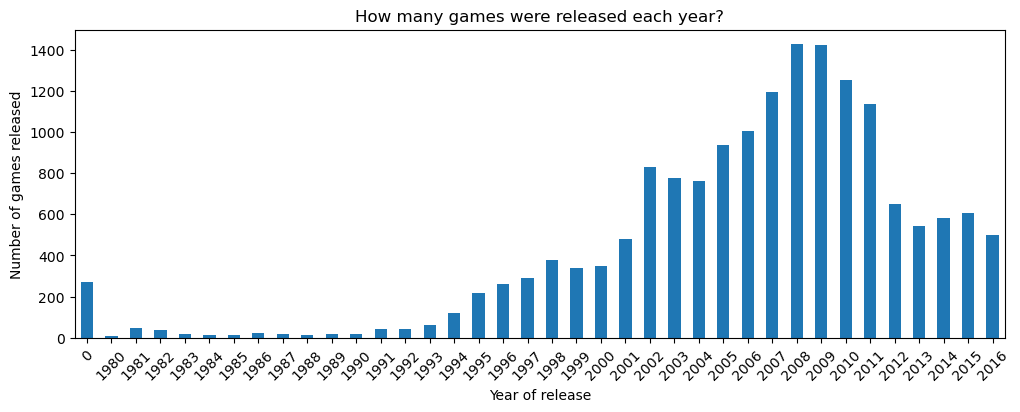

In [42]:
years_pivot = df.pivot_table(index='year_of_release', values='name', aggfunc='count')
years_pivot.plot(kind='bar', figsize=[12,4], rot=45, legend=False)
plt.xlabel('Year of release')
plt.ylabel('Number of games released')
plt.title('How many games were released each year?')

The 1980s and early 1990s - let's say, before 1995 - saw very few games released each year compared to the future, and are certainly not worth analyzing for current trends. I find it interesting that more games were released in the years preceding 2012 than were released afterwards. However, more data does not necessarily equate to better data or better potential for results. It's possible that games from large studios in 2012-2016 were more expensive and time-consuming to create, resulting in fewer games overall. The dataset may be incomplete, so the ideas we have regarding these trends may be unfounded.

Next let's figure out the most popular platforms and then take a look at when they were most popular.

## Global sales per platform per year

<Axes: title={'center': 'How much money did games from each platform make globally each year? (all-time top sellers)'}, xlabel='Year of release', ylabel='Global sales (USD million)'>

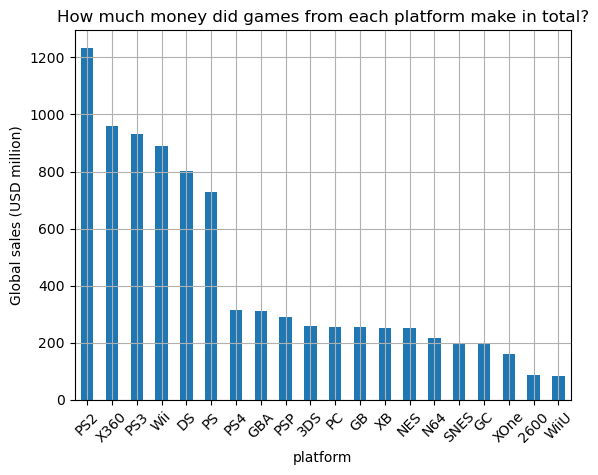

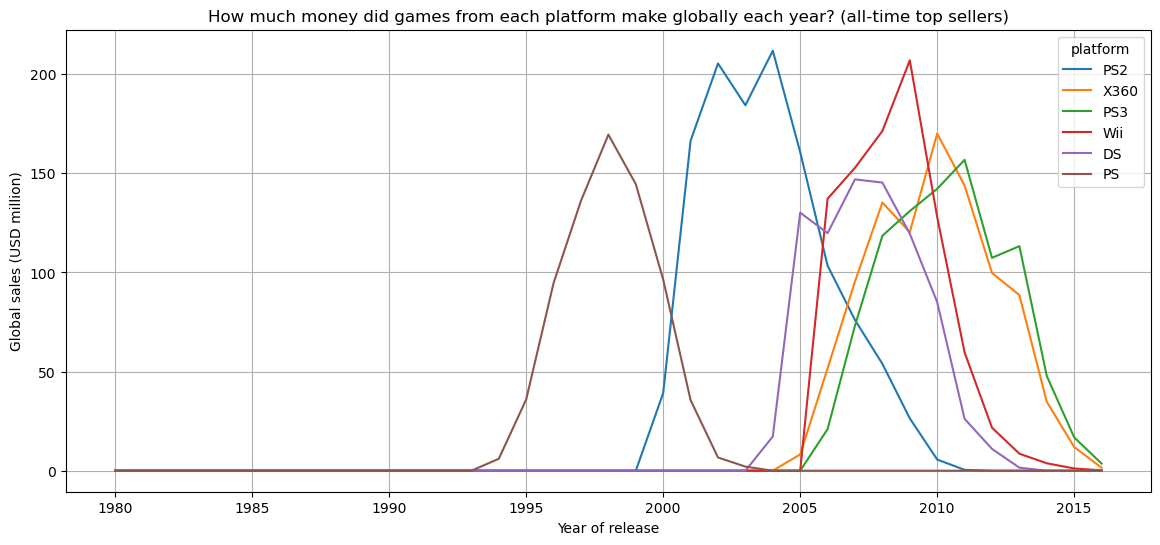

In [43]:
df_nonzero = df[df.year_of_release != 0] # Drop rows with an unknown release date, identified as '0'

# Look at top platforms based on total global game sales
pop_platforms = df_nonzero.pivot_table(index='platform', aggfunc='sum', values='global_sales').sort_values(by='global_sales', ascending=False)
pop_platforms_top_ten = pop_platforms.head(20)
pop_platforms_top_ten.plot(kind='bar', grid=True, rot=45, legend=False, ylabel='Global sales (USD million)', title='How much money did games from each platform make in total?')

# There are 6 platforms that distinctly sold the most, so let's look at the years those were popular
pop_platforms_year = df_nonzero.pivot_table(index='platform', aggfunc='sum', values='global_sales', columns='year_of_release', margins=True).sort_values(by='All', ascending=False)
pop_platforms_year_top_ten = pop_platforms_year.head(7).drop('All').T.drop('All').fillna(0)
# display(pop_platforms_year_top_ten)
pop_platforms_year_top_ten.plot(figsize=(14,6), grid=True, xlabel='Year of release', ylabel='Global sales (USD million)', title='How much money did games from each platform make globally each year? (all-time top sellers)')

The 6 platforms with the highest grossing games all peaked well before 2016, and in 2016 were making zero or nearly zero money. Visually we can see that:
    
    - PS lasted 1993 - 2004 (11 years); peaked 1998 (5 years from inception)
    - PS2 lasted 1999 - 2011 (12 years); peaked 2002-2004 (3-5 years from inception)
    - DS lasted 2003 - 2013 (10 years); peaked 2007 (5 years from inception)
    - Wii lasted 2005 - 2015 (10 years); peaked 2009 (4 years from inception)
    - Xbox 360 lasted 2004 - 2016 (12 years); peaked 2010 (6 years from inception)
    - PS3 lasted 2005 - 2016 (11 years); peaked 2011 (6 years from inception)

We can see that platforms tend to generate meaningful sales for about 10 years, and hit peak sales after about 4-6 years. The newer consoles tended to take slightly longer to reach these peak sales, with the Xbox 360 and PS3 taking 6 years to reach peak sales. These two platforms had more consistent sales than the Wii over their lifespans, but the Wii outsold both platforms until 2009, after which the Wii dropped sharply in popularity. This may be an important relationship to note for the following generation's platforms.

We can look at the PS platforms to get a sense of the relationship between subsequent platforms from the same company. The PS peaked in 1998, and the PS2 came out the following year in 1999. The PS's sales fell while the PS2's sales rose, finishing its peak in 2004. The PS3 was released the following year in 2005, and its sales rose while the PS2's sales fell.

Now I would like to look at other consoles' sales per year to figure out which consoles were growing in popularity in the years preceeding 2017. I'll only look at platforms that had nonzero game sales in 2016, and drop the platforms that we know were declining in popularity (Xbox 360, PS3, Wii).

<Axes: title={'center': 'How much money did games from each platform make globally each year? (modern platforms)'}, xlabel='Year of release', ylabel='Global sales (USD million)'>

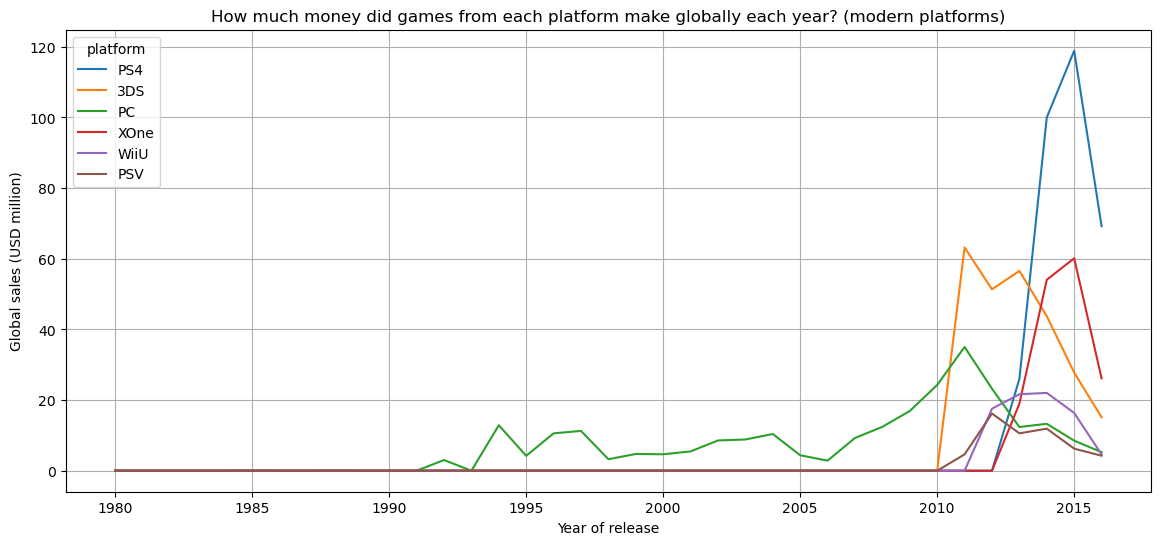

In [44]:
pop_platforms_year = pop_platforms_year.fillna(0)
pop_platforms_2016 = pop_platforms_year[pop_platforms_year[2016] != 0].drop(['All', 'X360', 'PS3', 'Wii']).T.drop('All')
pop_platforms_list = pop_platforms_2016.columns # Save list of popular platforms in 2016
# display(pop_platforms_2016)
pop_platforms_2016.plot(figsize=(14,6), grid=True, xlabel='Year of release', ylabel='Global sales (USD million)', title='How much money did games from each platform make globally each year? (modern platforms)')

The lines drop in 2016 because the data for 2016 is incomplete - we knew that 2016 data may be incomplete, but this confirms that idea. We will disregard these final points for this particular plot's analysis. From 2013/2014 to 2015, we see that the 3DS, PC, Wii U, and PSV are generally becoming less popular. The Xbox One and PS4 are the two platforms that are growing in popularity in 2015, and these are also the top sellers in 2015. These two platforms had zero sales in 2012, with their sales starting in 2013. So, it would make sense to start our analysis in 2013 in order to predict 2017 trends. 

It is worth noting that PC games have been selling since 1992, and have risen and fallen in popularity through the years - although the PC dipped in game sales heading into 2015, it may be worth examining due to its long-term consistency as a platform.

In conclusion - for the rest of our analysis, I will look at all platforms that sold games from 2013 to 2016, and focus especially on Xbox One, PS4, and PC platforms.

## Distributions of global sales

Let's make a boxplot showing what each game's sales were for each of the 6 platforms that made money in 2016.

In [45]:
df_2013 = df[df.year_of_release >= 2013]

array(['PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV'], dtype=object)

Text(0.5, 0, 'Global sales (USD million)')

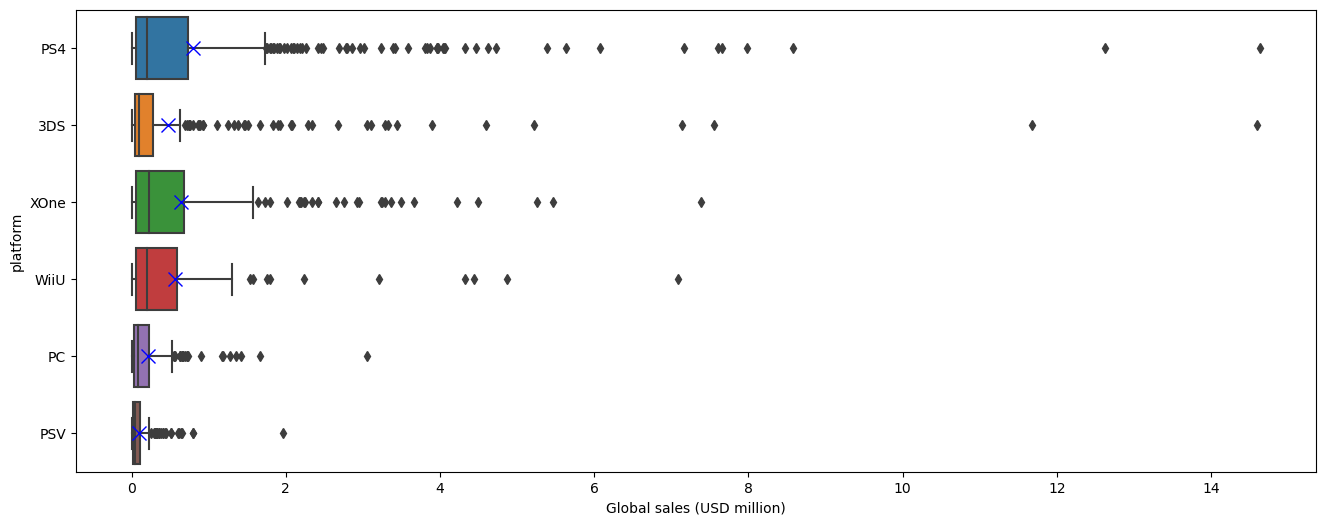

In [46]:
df_2013_box = df_2013[df_2013.platform.isin(pop_platforms_list)]
display(df_2013_box.platform.unique())
plt.figure(figsize=(16,6))
sns.boxplot(df_2013_box, x='global_sales', y='platform', showmeans=True, meanprops={"marker": "x", "markeredgecolor": "blue", "markersize": "10"})
plt.xlabel('Global sales (USD million)')

In [47]:
print("PS4 mean global game sales:", df_2013[df_2013.platform == 'PS4'].global_sales.mean())
print("Xbox One mean global game sales:", df_2013[df_2013.platform == 'XOne'].global_sales.mean())

PS4 mean global game sales: 0.8013775510204081
Xbox One mean global game sales: 0.6450202429149797


The PS4 and Xbox One platforms' global sales distributions are comparable when looking at each game, despite the PS4 selling about twice as much in games cumulatively as the Xbox One in 2015. Visually, the main difference between these two distributions is that the 75th percentile of PS4 game sales is slightly higher than that of the XBox One, and there are many more high outliers, many of which are higher than even the Xbox One's highest outlier. The mean global sales for PS4 games is not too much higher than that of Xbox One games, with PS4 games having mean global sales of 800,000 dollars and Xbox One games having mean global sales of 650,000 dollars. This indicates that the PS4 likely had many more games than the Xbox One in 2013-2016, which enabled them to generate so much more in overall sales.

In fact, all of the platforms' mean global sales per game are higher than their medians. Their means are bolstered by numerous high outliers.

The Wii U distribution looks similar to the Xbox One's, though is centered more to the left with a smaller median, mean, and 75th percentile. This indicates that the Wii U likely had far fewer games for sale than the Xbox One did in 2013-2016, since it generated much less in total global sales. This boxplot makes me want to also compare the Wii U with Xbox One, PS4, and PC platforms.

The PC global game sales are much lower than the PS4, Xbox One, and Wii U. 

## Scores vs sales correlations

Next I want to look at the correlation between user scores / critic scores and global sales for the Xbox One.

In [48]:
def show_correlations(platform):
    
    """
    This function takes a platform name as an input, and generates two side-by-side regression plots, 
    comparing user scores with global sales, and critic scores with global sales, respectively.
    It then prints the Pearson correlation coefficients for each relationship.
    """
    
    mask = (df_2013.platform == platform)
    
    fig, axes = plt.subplots(1, 2, figsize=(15,4))

    ax1 = sns.regplot(df_2013[mask], x='user_score', y='global_sales', ax=axes[0], color='orange')
    ax1.set_title('How do user scores for ' + platform + ' games correlate with global sales?')
    ax1.set_xlabel('User score')
    ax1.set_ylabel('Global sales (USD million)')
    ax1.set(ylim=(-1/2,6))

    ax2 = sns.regplot(df_2013[mask], x='critic_score', y='global_sales', ax=axes[1], color='blue')
    ax2.set_title('How do critic scores for ' + platform + ' games correlate with global sales?')
    ax2.set_xlabel('Critic score') 
    ax2.set_ylabel('Global sales (USD million)')
    ax2.set(ylim=(-1/2,6))
    
    plt.show()
    
    print(f"Pearson correlation coefficient between user scores and global sales for {platform}:", df_2013[mask].global_sales.corr(df_2013[mask].user_score))
    print(f"Pearson correlation coefficient between critic scores and global sales for {platform}:", df_2013[mask].global_sales.corr(df_2013[mask].critic_score))

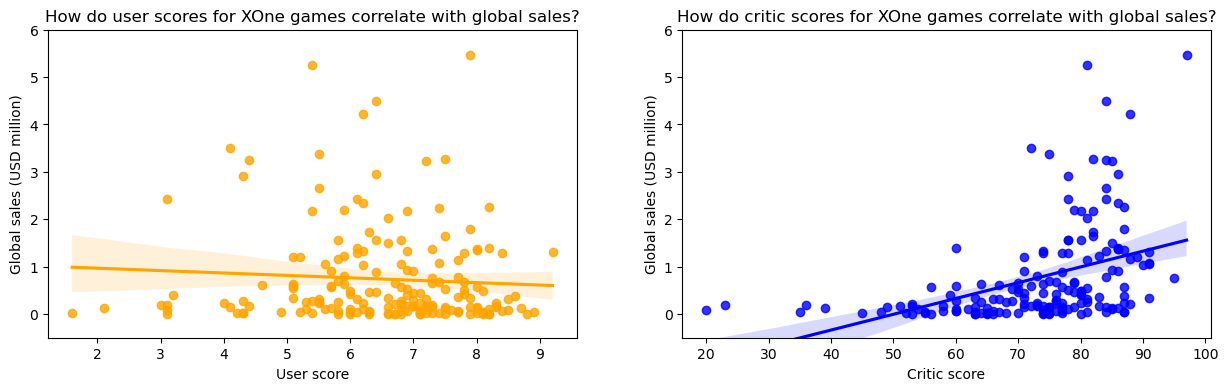

Pearson correlation coefficient between user scores and global sales for XOne: -0.06892505328279412
Pearson correlation coefficient between critic scores and global sales for XOne: 0.41699832800840175


In [49]:
show_correlations('XOne')

There appears to be no correlation between user scores and global game sales (-0.07 PCC), and a weak positive correlation between critic scores and global game sales (0.42 PCC). This shows that high critic reviews may be more important to the success of a game than high user reviews. Perhaps high critic reviews lead to users buying the game when it's released and paying full price, before users are able to write reviews. Or perhaps critic reviews are simply more influential to a potential consumer than user reviews when the consumer is shopping for games.

Now let's look at the same relationships, but for the other consoles that I will be focusing on - PS4, PC, and, now, Wii U also.

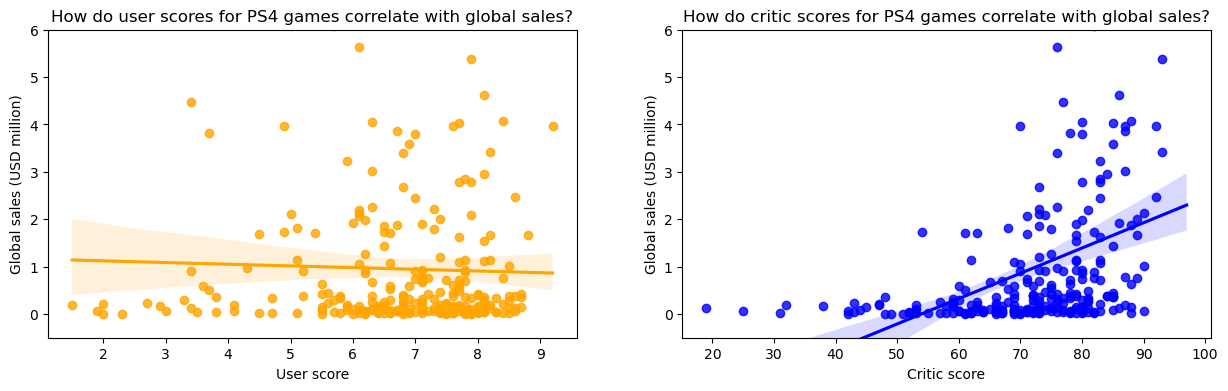

Pearson correlation coefficient between user scores and global sales for PS4: -0.031957110204556424
Pearson correlation coefficient between critic scores and global sales for PS4: 0.406567902061781


In [50]:
show_correlations('PS4')

The correlations for PS4 are nearly identical to those for the Xbox One - this makes sense because they are platforms of a similar style with similar games.

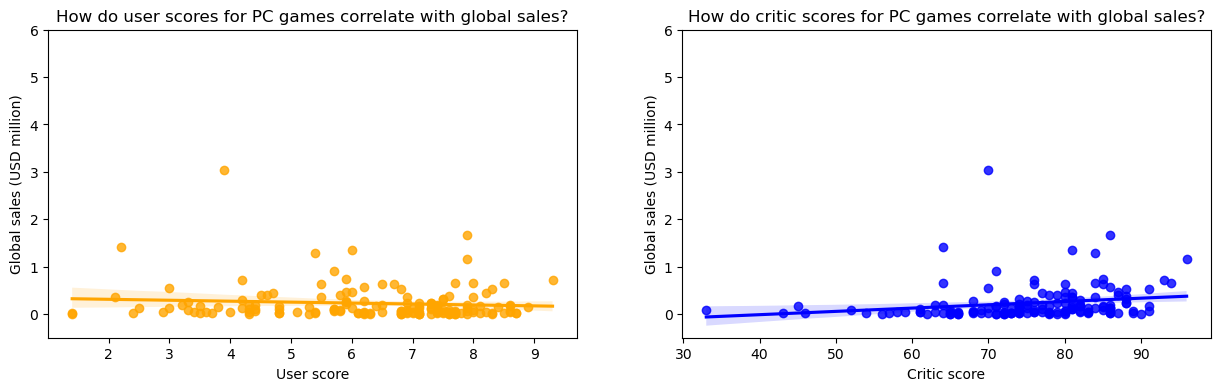

Pearson correlation coefficient between user scores and global sales for PC: -0.09384186952476739
Pearson correlation coefficient between critic scores and global sales for PC: 0.19603028294369382


In [51]:
show_correlations('PC')

The relationships between scores and global sales for PC look different than the same relationships for the XBox One and PS, but follow similar trends. There is still essentially no correlation between user scores and global sales, but only a very weak positive correlation between critic scores and global sales. Visually, however, only games that received a critic score of over 63 or so acheived an appreciable amount of global sales, which indicates a relationship, even if it is a weak one. The lack of high selling games on the PC may have weakened the correlation.

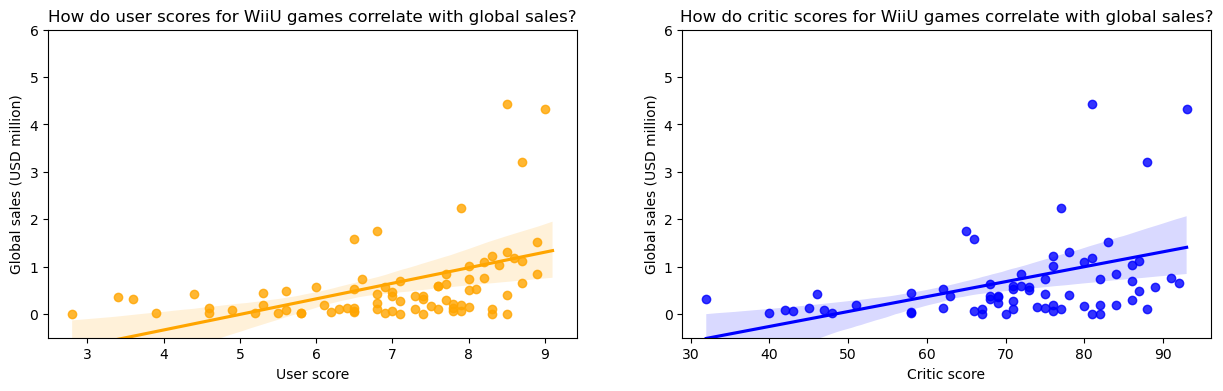

Pearson correlation coefficient between user scores and global sales for WiiU: 0.4193304819266187
Pearson correlation coefficient between critic scores and global sales for WiiU: 0.3764149065423912


In [52]:
show_correlations('WiiU')

Interestingly, in this case, the critic score has a a very similar relationship with global sales as the PS4 and Xbox One did - but the user score / global sales relationship is about equally correlated - they both have around a 0.4 correlation coefficient. It seems that users tend to agree with the critics with regards to game quality. 

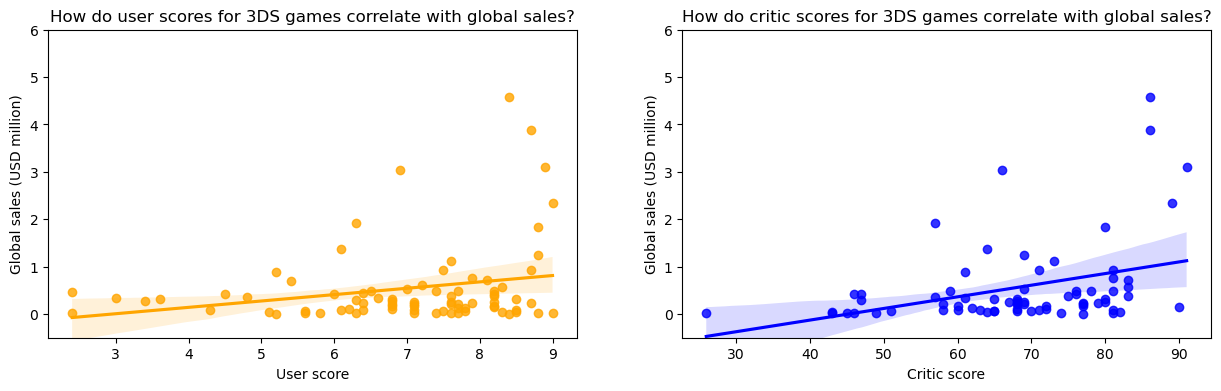

Pearson correlation coefficient between user scores and global sales for 3DS: 0.24150411773563016
Pearson correlation coefficient between critic scores and global sales for 3DS: 0.35705661422881035


In [53]:
show_correlations('3DS')

I'm not particularly interested in this platform in terms of its popularity, but I was curious to look at another Nintendo platform to see how it compared to the Wii U. It looks like the correlation between user scores and global sales is also stronger than that for the Xbox One, PS4, and PC - for upcoming Nintendo platforms, user scores may be a good indicator for global sales.

Overall, after looking at a variety of platforms, we can say that critic reviews and global sales may generally have a weak - but distinct - positive relationship, while user reviews generally are not correlated with global sales, except in the case of Nintendo platforms.

## Genre popularity

Now we are going to take a look at global sales for each genre to determine the most and least profitable genres from 2013-2016.

Text(0, 0.5, 'Genre')

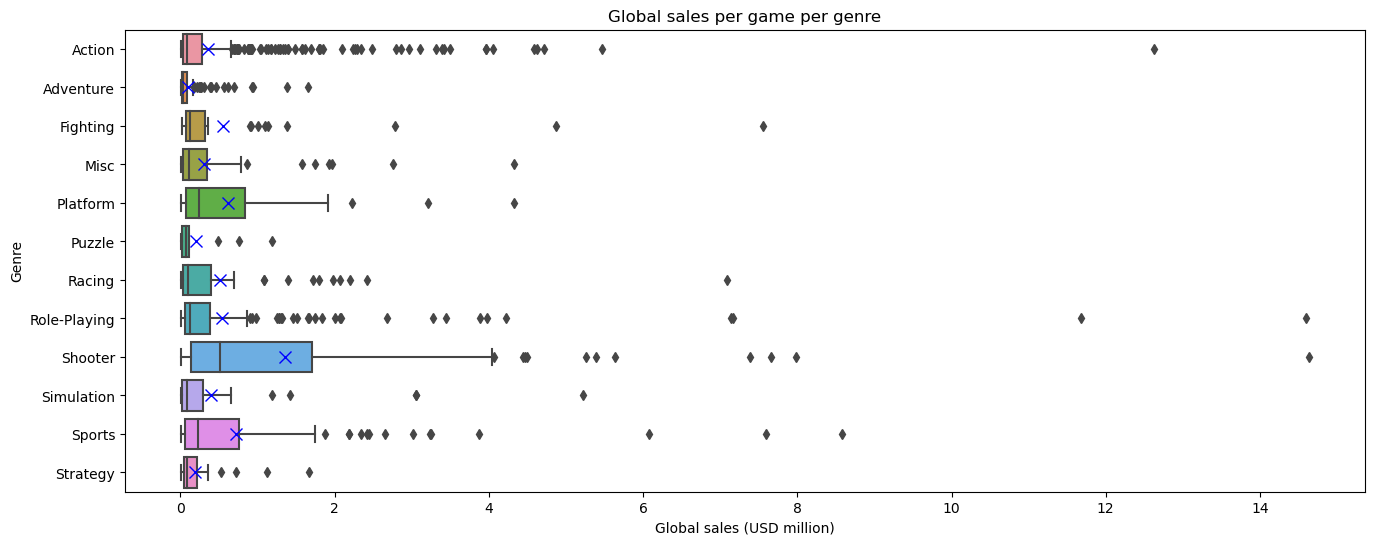

In [54]:
plt.figure(figsize=(16,6))
sns.boxplot(df_2013_box, x='global_sales', y='genre', showmeans=True, meanprops={"marker": "x", "markeredgecolor": "blue", "markersize": "8"})
plt.title('Global sales per game per genre')
plt.xlabel('Global sales (USD million)')
plt.ylabel('Genre')

In [55]:
pop_genres = df_2013_box.pivot_table(index='genre', values='global_sales', aggfunc=['median', 'mean']).sort_values(by=('mean', 'global_sales'))
pop_genres

,median,mean
,global_sales,global_sales
genre,,
Adventure,0.030,0.097515
Strategy,0.080,0.181837
Puzzle,0.065,0.195625
Misc,0.105,0.309464
Action,0.090,0.350669
Simulation,0.090,0.396200
Racing,0.100,0.506000
Role-Playing,0.120,0.543596


The adventure, puzzle, and strategy games have the lowest mean and median global sales. Shooter, platformer, and sports have the highest mean and median global sales. Games in the shooter and sports genres tend to involve a large number of online players and fast-moving gameplay, which may help to drive sales as compared to non-action-based, more intimate adventure, puzzle, and strategy games.

I want to check out the top-selling platform games, since these seem to buck the trend observed with the other top-selling genres.

In [56]:
df_2013_box[df_2013_box.genre == 'Platform'].sort_values(by='global_sales', ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
260,Super Mario 3D World,WiiU,2013,Platform,2.11,1.16,0.73,0.32,4.32,93.0,9.0,E
424,Super Mario Maker,WiiU,2015,Platform,1.18,0.89,0.94,0.20,3.21,88.0,8.7,E
720,New Super Luigi U,WiiU,2013,Platform,1.25,0.62,0.18,0.18,2.23,77.0,7.9,E
908,LittleBigPlanet 3,PS4,2014,Platform,0.66,0.93,0.01,0.31,1.91,79.0,7.1,E
912,Donkey Kong Country Returns,3DS,2013,Platform,0.74,0.62,0.41,0.13,1.90,NaN,NaN,RP
952,Kirby: Triple Deluxe,3DS,2014,Platform,0.61,0.34,0.79,0.09,1.83,80.0,8.8,E
1028,Knack,PS4,2013,Platform,0.43,0.68,0.42,0.20,1.73,54.0,6.5,E10+
1216,Ratchet & Clank (2016),PS4,2016,Platform,0.50,0.76,0.04,0.24,1.54,NaN,NaN,RP
1231,Donkey Kong Country: Tropical Freeze,WiiU,2014,Platform,0.70,0.55,0.16,0.12,1.53,83.0,8.9,E
1290,LEGO City Undercover,3DS,2013,Platform,0.52,0.77,0.07,0.11,1.47,NaN,NaN,RP


We see that the top 3 best-selling platformer games are for the Wii U, and that 7 of the top 10 best-selling platformer games were released on Nintendo platforms. It seems that Nintendo platforms continue to experience different trends than the Xbox One and PS4.

# Regional User Profiles

In this next section of analysis, we will analyze the dataset for games released in 2013-2016 based on regional sales rather than global sales. Nintendo platforms seem to follow different trends than the other top selling platforms in this time period, so I would like to see if these trends also vary by region. North America (NA), Europe (EU), and Japan (JP) are the regions whose sale data is contained in this dataset. Instead of only looking at the platforms whose games sold in 2016, I will look at platforms whose games sold between 2013 and 2016. 

## Top five platforms per region

In [57]:
def analyze_regions(index, values):
    
    """
    Creates a pivot table, taking index and values as input, and sums the values column, displaying the top five items.
    """
    
    display(df_2013.pivot_table(index=index, values=values, aggfunc='sum').sort_values(by=values, ascending=False).head())

In [58]:
analyze_regions('platform', 'na_sales')
analyze_regions('platform', 'eu_sales')
analyze_regions('platform', 'jp_sales')

,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


In North America and Europe, PS4 is the top selling platform, and their top five selling platforms are all the same. The Xbox One trails the PS4 by a bit in North America, but is almost 1/3 the sales of the PS4 in Europe. In Japan, the Xbox One does not crack the top five list, and the PS4 takes fourth best selling platform. The 3DS is a top five best seller in each region, but was the top seller in Japan by far - the second best seller (PS3) is about 1/3 the sales as the 3DS. The PSV is another handheld platform that cracked the top five list in Japan, along with the Wii U, another Nintendo platform.

Overall, the Playstation and Xbox Consoles performed the best in North America and Europe, while Japan preferred the Nintendo, handhelds, and Playstation platforms.

## Top five genres per region

In [59]:
analyze_regions('genre', 'na_sales')
analyze_regions('genre', 'eu_sales')
analyze_regions('genre', 'jp_sales')

,na_sales
genre,
Action,126.05
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.20
Fighting,7.65
Shooter,6.61


As with the trends from top platforms per region, the top five North American and Europe genres are pretty similar, while Japan's top genres deviate a bit. North America and Europe share their top four genres, with action, shooter, and sport genres taking first, second, and third places. Action and shooter genres also placed in Japan's top five, but their top seller was role-playing games - which also cracked the top genres in North America and Europe. 

Notably, games from the action genre placed very highly in all three regions, and role-playing and shooter games were also found in the top five genres per region.

## ESRB ratings vs sales per region

Text(0.5, 1.0, 'Regional sales for each ESRB rating of video game')

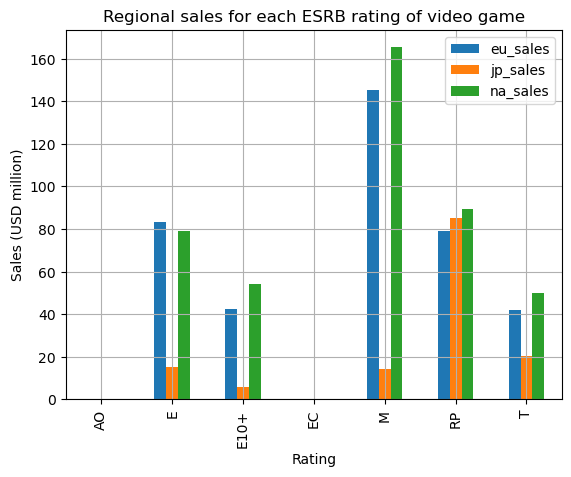

In [60]:
rating_sales = df_2013.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
rating_sales.plot(kind='bar', grid=True)
plt.ylabel('Sales (USD million)')
plt.xlabel('Rating')
plt.title('Regional sales for each ESRB rating of video game')

The most popular rating in North America and Europe is the M rating, for "mature", while Japan's most popular rating is RP, for "rating pending". Earlier, we converted a number of unrated games to RP, so RP essentially means that a rating is missing. In Japan, video game content rating is not required by law, and the ESRB system is not local to Japan, so there may simply be more games in Japan that are unrated, at least to ESRB standards. There are also a number of RP games sold in North America and Europe, so perhaps a large number of ESRB rating data is simply missing - about the same amount of money was generated from RP games in each of the three regions, so this could perhaps be attributed to missing data.

Overall, North America and Europe are very similar in terms of popular ratings, with M being by far the most popular, while in Japan, after RP games, T (for "teen") games are most popular. T games are just about tied with E10+ (for "everyone 10+") games for least popular in North America and Europe.

# Statistical Data Analysis

We will now use statistical tests to determine whether or not the relationships between user scores and platforms/genres from 2013 to 2016 are significant.

## Compare user scores of Xbox One & PC

We will use a t-test with two independent samples. First I want to check whether or not the distributions of user scores for Xbox One and PC games are normal, and how many observations are in each sample - if the sample sizes are larger than 50, we can be more lenient with the normality of the distributions. Then I will use Levene's test to determine whether or not the variances are about equal before performing the t-test.

In [61]:
# Collect data into samples, omitting nan values
xbox_one_user_scores = df_2013[df_2013.platform == 'XOne'].user_score.dropna()
pc_user_scores = df_2013[df_2013.platform == 'PC'].user_score.dropna()

<Axes: >

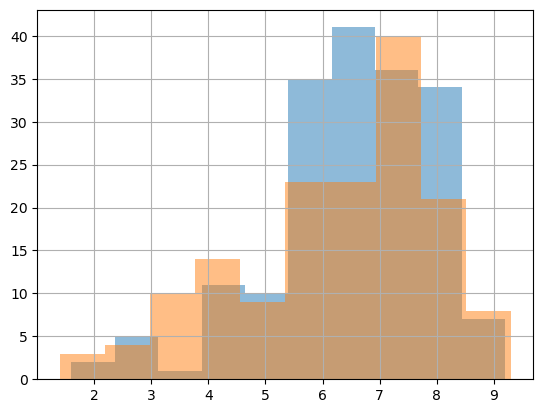

In [62]:
xbox_one_user_scores.hist(alpha=.5)
pc_user_scores.hist(alpha=.5)

In [63]:
print("Number of user score observations for Xbox One platform:", xbox_one_user_scores.shape[0])
print("Number of user score observations for PC platform:", pc_user_scores.shape[0])

Number of user score observations for Xbox One platform: 182
Number of user score observations for PC platform: 155


The distributions are definitely left skewed, but do not contain any extraordinary outliers. The groups both contain over 50 data points, and are of reasonably similar size, so it will be fair to use a t-test.

In [64]:
print("Variance of user score observations for Xbox One platform:", xbox_one_user_scores.var())
print("Variance of user score observations for PC platform:", pc_user_scores.var())

Variance of user score observations for Xbox One platform: 1.9069968429360702
Variance of user score observations for PC platform: 3.035892752408884


The null hypothesis for Levene's test is that there is no statistically significant difference between the variances of the groups.

The alternative hypothesis is that there is a statistically significant difference between the groups' variances.

An alpha of 0.05 is set for Levene's test. If the resultant p-value is less than 0.05, the variances can be considered to be different.

In [65]:
levene(xbox_one_user_scores, pc_user_scores)

LeveneResult(statistic=8.44812129543499, pvalue=0.003897553110130418)

Looking at the variances, and at the results of Levene's test, the variances do seem fairly different. The p-value is less than 0.05. We will be able to use a t-test with two independent samples by telling the function that the variances are not equal.

The null hypothesis for this t-test is that there is no statistically significant difference between the mean user scores for the Xbox One and PC platforms.

The alternative hypothesis is that the difference between the mean user scores for the Xbox One and PC platforms is statistically significant.

The alpha will be set at 0.05, which is standard. I would set it lower, but I want to make sure that I catch more trends rather than missing any.

In [66]:
ttest_ind(xbox_one_user_scores, pc_user_scores, equal_var=False)

Ttest_indResult(statistic=1.45192815744488, pvalue=0.14759594013430463)

The null hypothesis is not rejected by this relatively large p-value (0.15 > 0.05). We can not be certain that there is any statistically signifciant difference between the mean user scores for games on the Xbox One and PC platforms in 2013-2016.

## Compare user scores of Action and Sports genres

I will be using a t-test with two independent samples to compare the mean user scores for games of the action and sports genres. As with the last statistical test, I will be checking the groups for normality, equivalent sample size, and equivalent variances before using the t-test.

In [67]:
action_user_scores = df_2013[df_2013.genre == 'Action'].user_score.dropna()
sports_user_scores = df_2013[df_2013.genre == 'Sports'].user_score.dropna()

In [68]:
# Take a look at the means of these two groups
print("Action games - mean user score:", action_user_scores.mean())
print("Sports games - mean user score:", sports_user_scores.mean())

Action games - mean user score: 6.837532133676092
Sports games - mean user score: 5.238124999999999


<Axes: >

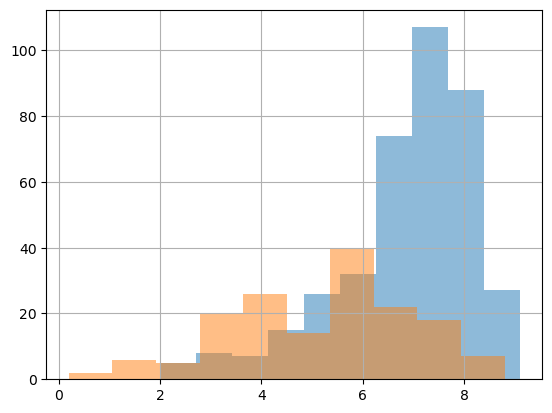

In [69]:
action_user_scores.hist(alpha=.5)
sports_user_scores.hist(alpha=.5)

In [70]:
display(action_user_scores.shape[0])
display(sports_user_scores.shape[0])

389

160

The groups are of much different sizes and shapes, but the sports user scores seem approximately normal, and the action user scores, while left-skewed, do not have any extraordinary outliers.

The null hypothesis for Levene's test is that there is no statistically significant difference between the variances of the groups.

The alternative hypothesis is that there is a statistically significant difference between the groups' variances.

An alpha of 0.05 is set for Levene's test. If the resultant p-value is less than 0.05, the variances can be considered to be different.

In [71]:
levene(action_user_scores, sports_user_scores)

LeveneResult(statistic=26.20600718947607, pvalue=4.2566688218274047e-07)

The variances seem to be different, based on the very low p-value. We will simply set the variance to be unequal in the upcoming t-test.

The null hypothesis for this t-test is that there is no statistically significant difference between the mean user scores for the action and sports genres.

The alternative hypothesis is that the difference between the mean user scores for the action and sports genres is statistically significant.

The alpha will be set at 0.05, which is standard. I would set it lower, but I want to make sure that I catch more trends rather than missing any.

In [72]:
ttest_ind(action_user_scores, sports_user_scores, equal_var=False)

Ttest_indResult(statistic=10.233428417448625, pvalue=1.4460039700704315e-20)

This extremely low p-value rejects the null hypothesis that the mean user scores for the action and sports genres are equivalent. The mean user score for action games in 2013-2016 appears to be higher than the mean user score for sports games, statistically.

## Comparing user scores of XOne, PC, PS4, & WiiU

* I want to try a statistical analysis more complex than a t-test.

First we will compare typical user score of the Xbox One, PC, PS4, and WiiU platforms. This will require a one-way Analysis of Variance (ANOVA) test, because we are comparing the means of more than two groups, and we have one independent categorical variable (platform) and one dependent quantitative variable (user score). 

For all of these tests, I will use a type I error rate of 0.05. This and 0.01 are standard, and I am more concerned about not spotting an important trend than I am about finding a trend where none exists.

The assumptions of the one-way ANOVA test include:

    1. Independence of observations
    2. Normally-distributed dependent variable
    3. Approximate equivalence of variances
    
We know the observations to be independent. (Assumption 1)    

First we will use a normality test to determine whether or not the distributions of user scores for each platform are normal. However, if the distributions are not normal, we should check that all groups have a sample size of >50, and that they are of similar size. (Assumption 2)

Then we will use Levene's test to determine whether or not the variances of user scores for each platform are approximately equal. However, if the variances are considered to be different by Levene's test, we will check the variances to make sure that the largest variance is no more than four times the smallest variance, as this seems to be a common rule of thumb. (Assumption 3)

If these assumptions are met, we will use a one-way ANOVA test to determine whether there are any differences between the means of the platforms.

    If we use the one-way ANOVA test, we will then perform a Tukey test to determine which differences are statistically significant.

If the prior assumptions are not met, we may have to look into either a Kruskal-Wallis H-test or the Alexander-Govern test, though these would be less powerful.

In [73]:
ps4_user_scores = df_2013[df_2013.platform == 'PS4'].user_score.dropna()
wii_u_user_scores = df_2013[df_2013.platform == 'WiiU'].user_score.dropna()

In [74]:
print(normaltest(xbox_one_user_scores))
print(normaltest(pc_user_scores))
print(normaltest(ps4_user_scores))
print(normaltest(wii_u_user_scores))

NormaltestResult(statistic=22.74026027667708, pvalue=1.1534936880652902e-05)
NormaltestResult(statistic=12.798802901157694, pvalue=0.001662552095013322)
NormaltestResult(statistic=56.451629696132755, pvalue=5.516763472334615e-13)
NormaltestResult(statistic=10.988287882303378, pvalue=0.00411077402419037)


The low p-values (<0.05) reject each test's null hypothesis that its distribution is normal.

In [75]:
print("Number of user score observations for Xbox One platform:", xbox_one_user_scores.shape[0])
print("Number of user score observations for PC platform:", pc_user_scores.shape[0])
print("Number of user score observations for PS4 platform:", ps4_user_scores.shape[0])
print("Number of user score observations for Wii U platform:", wii_u_user_scores.shape[0])

Number of user score observations for Xbox One platform: 182
Number of user score observations for PC platform: 155
Number of user score observations for PS4 platform: 257
Number of user score observations for Wii U platform: 80


I see that the sample sizes are much different from each other. Xbox One and PS4 were close, but the rest are not.

<Axes: >

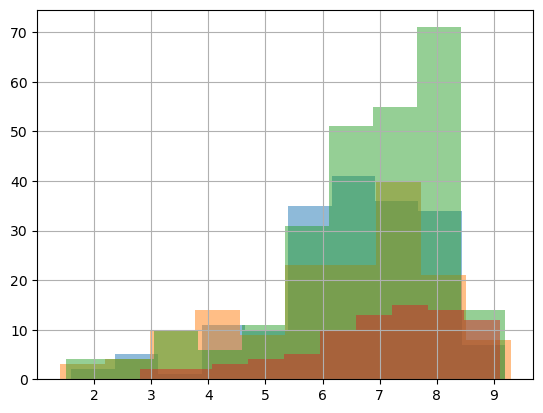

In [76]:
# Plotting the histograms for each group to see if they look similar or not.
xbox_one_user_scores.hist(alpha=0.5)
pc_user_scores.hist(alpha=0.5)
ps4_user_scores.hist(alpha=0.5)
wii_u_user_scores.hist(alpha=0.5)

All distributions look about similar, with left skews and modes in the same general area.

The null hypothesis for Levene's test is that there is no statistically significant difference between the variances of the groups.

The alternative hypothesis is that there is a statistically significant difference between the groups' variances.

An alpha of 0.05 is set for Levene's test. If the resultant p-value is less than 0.05, the variances can be considered to be different.

In [77]:
levene(xbox_one_user_scores, pc_user_scores, ps4_user_scores, wii_u_user_scores)

LeveneResult(statistic=3.839736752463445, pvalue=0.009614910668042794)

Because the p-value is less than the alpha setting (0.01 < 0.05), the variances are not considered to be equivalent by Levene's test.

In [78]:
xbox_one_user_scores.var()

1.9069968429360702

In [79]:
pc_user_scores.var()

3.035892752408884

In [80]:
ps4_user_scores.var()

2.130084812743191

In [81]:
wii_u_user_scores.var()

1.9774113924050647

The largest variance is well within the bounds of 4x the smallest variance. 

I would like to go ahead and use a one-way ANOVA, even though the groups are not normally distributed and are of dissimilar size. 

***

Dear reviewer,

What might you do in this situation? Is there a handy way to transform the data so that it is more normally distributed? Is it acceptable to remove outliers (such as bottom 5% and top 5% of data)? Is the rule of thumb I used for comparing variances actually a standard idea?

If my data were more normal or my sample sizes were more equivalent, would I be running an ANOVA test effectively?

***

I will now be running a one-way ANOVA test. 

The null hypothesis is that the there is no statistically significant difference between any of the mean user scores for the Xbox One, PC, PS4, and Wii U platforms.

The alternative hypothesis there is a statistically significant difference between any of the mean user scores for the Xbox One, PC, PS4, and Wii U platforms.

The alpha is set at 0.05, so a resultant p-value of less than 0.05 indicates that there is a statistically significant difference between the mean user scores of at least one pair in the groups.

In [82]:
f_oneway(xbox_one_user_scores, pc_user_scores, ps4_user_scores, wii_u_user_scores)

F_onewayResult(statistic=5.542062975744718, pvalue=0.0009231325780304652)

The low p-value (<0.05) suggests there is a statistically significant difference between some of the means of these groups.

I am realizing that Tukey's test requires the data to be in a dramatically different format than it is currently.

I will make new datasets that include platform information with each user score, and concatenate these into a single dataframe.

In [83]:
xbox_one_user_scores_2 = df_2013[df_2013.platform == 'XOne'][['user_score', 'platform']].dropna()
pc_user_scores_2 = df_2013[df_2013.platform == 'PC'][['user_score', 'platform']].dropna()
ps4_user_scores_2 = df_2013[df_2013.platform == 'PS4'][['user_score', 'platform']].dropna()
wii_u_user_scores_2 = df_2013[df_2013.platform == 'WiiU'][['user_score', 'platform']].dropna()

In [84]:
tukey_data = pd.concat([xbox_one_user_scores_2, pc_user_scores_2, ps4_user_scores_2, wii_u_user_scores_2]).reset_index(drop=True)

Now we will run the Tukey test. Running six t-tests would allow six opportunities for error, while this test only allows for one opportunity.

It will run a t-test on each combination of groups, and indicate whether "reject" equals "True" or "False". If reject==True, then the null hypothesis is rejected for that pair. If reject==False, then the null hypothesis is not rejected for that pair. We will define the null hypotheses shortly.

The null hypothesis for each of these pairs is that there is no statistically significant difference between the mean user scores for games from the tested platforms.

The alternative hypothesis for each of these pairs is that there is some statistically significant difference between the mean user scores for games from the tested platforms.

The alpha will be set at 0.05. I want to find any patterns that have a decent chance of being a trend.

In [85]:
print(tukey(tukey_data.user_score, tukey_data.platform, 0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    PC    PS4   0.4786 0.0098  0.0848 0.8723   True
    PC   WiiU   0.7478 0.0018  0.2148 1.2808   True
    PC   XOne   0.2518 0.4188 -0.1714 0.6749  False
   PS4   WiiU   0.2693 0.5004 -0.2264  0.765  False
   PS4   XOne  -0.2268 0.4039 -0.6019 0.1483  False
  WiiU   XOne  -0.4961 0.0673 -1.0155 0.0233  False
---------------------------------------------------


The Tukey test rejects the null hypothesis for PC / PS4 and for PC / WiiU. There appears to be a statistically significant difference between mean user scores for games on PC and on PS4, and for games on PC and WiiU. In each case, the PC received a lower mean user score.

For all other pairings, the null hypothesis was not rejected, so there may not be any statistically significant differences between the mean scores of those groups.

In [86]:
# Display means and variances
tukey_data.pivot_table(index='platform', values='user_score', aggfunc=['mean', 'var'])

# I am realizing that creating this tukey_data dataset earlier and using pivot tables for summary statistics would have made things easier for me in some respects.

,mean,var
,user_score,user_score
platform,,
PC,6.269677,3.035893
PS4,6.748249,2.130085
WiiU,7.017500,1.977411
XOne,6.521429,1.906997


# Conclusion

My goal for this project was to discover trends for video game sales heading into 2017. From the start, I was mostly focused on data from 2013 to 2016, because I knew that the two most modern platforms in 2017 had come out in late 2012.

During the initial preprocessing stage, I standardized the column names and checked for duplicates. Then I went through each column, checked for reasonable values, changed datatypes into datatypes that I could better work with, and filled in missing values in most cases. For string columns, I tended to replace nans with something like "Unknown", and for numerical columns, I typically made sure that the missing values were nans or 0's so that I could change the datatypes to integer or float. There was a good bit of missing data for the user / critic scores and ESRB ratings, but the sales data was fully complete. I added a column summing each game's regional sales into a "global sales" column.

With my more useable dataframe, I began to analyze the data, first looking for trends over the years, and then zooming in to just the later years. I found that very few games were released in the 1980's and early 1990's, and the release of games peaked in 2008-2009. The highest grossing platforms of all time were not selling in 2013-2016, so rather than using this data directly for 2017 trend prediction, I looked at the lifespans of these consoles. I found that the popular platforms predating 2013 sold for around 10-11 years, and peaked at around 5-6 years. This indicates that platforms which started to sell games around 2013 may expect an increase in sales each year until peaking in about 2018-2019, though increasingly modern technology may be able to lengthen the lifespans of the more modern platforms. The PS4 and Xbox One were increasing in sales and were the highest selling platforms in 2015 (data for 2016 was incomplete). The PC was not selling well, though its lifespan was markedly longer than any of the other platforms, so I decided to also focus on its data due to its longevity. 

Individual games for the PS4, Xbox One, and Wii U had high mean global sales compared to the other consoles. Games released on these platforms tended to be profitable in 2013-2016. I then wanted to see how user and critic scores played into global sales for games on these platforms. Critic scores were more highly correlated with global sales than were user scores and global sales; Nintendo platforms (i.e. Wii U & 3DS) had a higher correlation between user scores and global sales than the other platforms. Genre also had an impact on global sales in 2013-2016, with shooter, sport, and platformer games having the highest global sales, and adventure, strategy, and puzzle games having the lowest global sales. 

Looking at game sales by region, North America and Europe showed similarities in terms of preferred genre, platform, and ESRB rating; PS4 and Xbox One were the preferred modern platforms, action, shooter, and sports were the preferred genres, and Mature games were the most popular ESRB rating. Japan differed in that its preferred platforms were the Nintendo, handhelds, and Playstation platforms, its preferred genres were role-playing, action, and miscellaneous, and its most popular ESRB rating was Rating Pending - possibly because ESRB ratings are less prevalent in Japan.

I wanted to answer some key questions using statistical tests to better define trends. 

- I compared the mean user scores of Xbox One and PC games in 2013-2016. The idea that the mean user scores for these two platforms were equivalent was not rejected. The user scores for games on these platforms to not appear to be significantly different based on this data. 

- I then compared the mean user scores of Action and Sports games in 2013-2016. The idea that the mean user scores for these two genres were equivalent was rejected. The user scores for these genre appear to be significantly different, with action games being rated more highly.

- I also wanted to try using ANOVA and Tukey's test to compare the mean user scores for the four main platforms I chose to look at: Xbox One, PC, PS4, and Wii U. The results showed that the mean user scores for PS4 and Wii U games are both statistically significantly higher than the mean user scores for PC games, and it revealed no other statistically significant differences between platforms.

Putting together the trends we've found, we can predict that the Xbox One and PS4 platforms are on the rise as the most profitable platforms overall, but individual games for the Xbox One, PS4, and Wii U tend to sell about equally well. We can expect games for Xbox One and PS4 to perform well in North America and Europe, while Nintendo and handheld platforms will likely excel in Japan. Action, shooter, and role-playing games will likely sell well globally. We can compare features of new games to the data analyzed in this notebook to help us predict that particular game's performance in 2017.

On a personal level, in the course of this project, I got more experience processing and analyzing data, and started to thinking about predicting future data rather than simply describing existing data. I am excited to explore this facet of data analysis more as I move into learning to use predictive tools like machine learning. I am trying to push my understanding of statistics beyond simple t-tests, so trying out ANOVA was a good learning experience for me.